In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torchdata
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import os
import sys
sys.path.append("/project")

from model.hydro.gr4j_prod import ProductionStorage
from model.utils.training import EarlyStopper
from model.utils.evaluation import evaluate
from data.utils import read_dataset_from_file, get_station_list

In [3]:
data_dir = '/data/camels/aus/'
sub_dir = 'no-scale'
station_id = '105105A' # '318076'
run_dir = '/project/results/hygr4j'

window_size = 7
x1 = 530.927 #817.2529155367329
weight_decay = 0.08

In [4]:
print(f"Reading data for station_id: {station_id}")
train_ds, val_ds = read_dataset_from_file(data_dir, 
                                          sub_dir, 
                                          station_id=station_id)

Reading data for station_id: 105105A


In [5]:
if not os.path.exists(run_dir):
    os.makedirs(run_dir)

plot_dir = os.path.join(run_dir, 'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

t_train, X_train, y_train = train_ds.tensors
t_val, X_val, y_val = val_ds.tensors

y_mu = y_train.mean(dim=0)
y_sigma = y_train.std(dim=0)

In [6]:
X_train = torch.nan_to_num(X_train)
X_val = torch.nan_to_num(X_val)


y_train = (y_train - y_mu)/y_sigma
y_val = (y_val - y_mu)/y_sigma


In [7]:
prod_store = ProductionStorage(x1=x1)
inp_train = prod_store(X_train, include_x=True)[0]

In [8]:
def create_sequence(X, y, window_size):

        assert window_size is not None, "Window size cannot be NoneType."

        # Create empyty sequences
        Xs, ys = [], []

        # Add sequences to Xs and ys
        for i in range(1, len(X) - window_size):
            Xs.append(torch.concat([
                                    X[i: (i + window_size)], 
                                    y[i-1: (i + window_size - 1)]
                                ], dim=1)
                    )
            ys.append(y[i + window_size - 1])

        Xs, ys = torch.stack(Xs), torch.stack(ys)
        # Xs = torch.unsqueeze(Xs, dim=3)

        return Xs, ys

In [9]:
X_train_seq, y_train_seq = create_sequence(inp_train, y_train, 
                                           window_size=window_size)

X_train_seq.shape, y_train_seq.shape

(torch.Size([8389, 7, 10]), torch.Size([8389, 1]))

In [10]:
inp_val = prod_store(X_val, include_x=True)[0]
X_val_seq, y_val_seq = create_sequence(inp_val, y_val, 
                                       window_size=window_size)
X_val_seq.shape, y_val_seq.shape

(torch.Size([3592, 7, 10]), torch.Size([3592, 1]))

In [11]:
train_ds = torchdata.TensorDataset(X_train_seq, y_train_seq)
train_dl = torchdata.DataLoader(train_ds, batch_size=256, shuffle=False)

val_ds = torchdata.TensorDataset(X_val_seq, y_val_seq)
val_dl = torchdata.DataLoader(val_ds, batch_size=256, shuffle=False)

In [12]:
from model.ml.lstm_flax import LSTM
from model.utils.evaluation import evaluate
from tqdm import tqdm

import jax
import jax.numpy as jnp
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax 

In [13]:
hidden_dim = 16
lstm_dim = 32
dropout = 0.2
n_features = 10
output_dim = 1

n_epoch = 150
lr = 5e-4

In [14]:
model = LSTM(hidden_dim=hidden_dim,
            lstm_dim=lstm_dim,
            output_dim=output_dim,
            dropout_p=dropout)

In [15]:
@struct.dataclass
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output('loss')

In [16]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    key: jax.random.KeyArray

def create_train_state(module, rng, lr):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones([1, window_size, n_features]))['params'] # initialize parameters by passing a template image
    tx = optax.adamw(lr, b1=0.89, b2=0.97, weight_decay=weight_decay)
    return TrainState.create(
        apply_fn=module.apply, 
        params=params, tx=tx,
        key=rng['dropout'],
        metrics=Metrics.empty())

In [17]:
@jax.jit
def train_step(state, batch, targets):
    """Train for a single step."""
    def loss_fn(params):
        preds = state.apply_fn({'params': params}, batch,
                                rngs={'dropout': jax.random.PRNGKey(1)})
        loss = optax.l2_loss(preds, targets).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [18]:
@jax.jit
def compute_metrics(*, state, batch, targets):
    
    preds = state.apply_fn({'params': state.params}, batch,
                            rngs={'dropout': jax.random.PRNGKey(1)})
    loss = optax.l2_loss(preds, targets).mean()
    metric_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

In [19]:
init_rngs = {'params': jax.random.PRNGKey(0), 'dropout': jax.random.PRNGKey(1)}

In [20]:
state = create_train_state(model, init_rngs, lr)

In [21]:
metrics_history = {'train_loss': [],
                   'test_loss': []}

In [22]:
# Early stopping
early_stopper = EarlyStopper(patience=5, min_delta=0.001)

In [23]:
pbar = tqdm(range(1, n_epoch+1))

for epoch in pbar:

    model.training = True

    # Train step
    for step, (batch, targets) in enumerate(train_dl):

        batch = batch.detach().numpy()
        targets = targets.detach().numpy()

        state = train_step(state, batch, targets)
        state = compute_metrics(state=state, batch=batch, targets=targets)
    
    for metric, value in state.metrics.compute().items(): # compute metrics
        metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty())

    # Validation step
    test_state = state
    model.training = False
    for step, (batch, targets) in enumerate(val_dl):
        batch = batch.detach().numpy()
        targets = targets.detach().numpy()
        test_state = compute_metrics(state=test_state, batch=batch, targets=targets)

    for metric, value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)
    
    pbar.set_description(f"""Epoch {epoch}/{n_epoch} loss: {metrics_history['train_loss'][-1]:.4f} val_loss: {metrics_history['test_loss'][-1]:.4f}""")

    if early_stopper.early_stop(metrics_history['test_loss'][-1]):
        break

Epoch 63/150 loss: 0.1458 val_loss: 0.2006:  41%|████▏     | 62/150 [01:21<01:55,  1.31s/it]


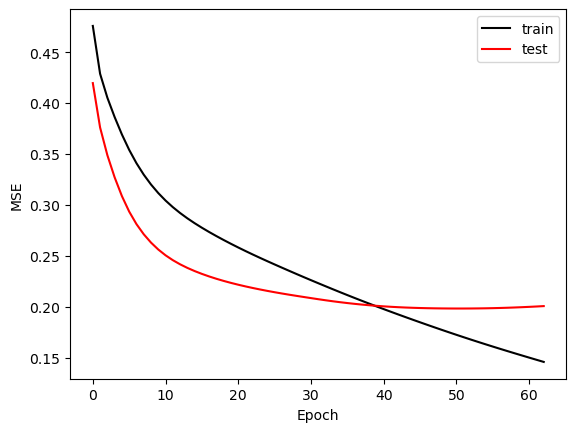

In [24]:
train_loss = jnp.array(metrics_history['train_loss'])
test_loss = jnp.array(metrics_history['test_loss'])

plt.plot(train_loss, color='black', label='train')
plt.plot(test_loss, color='red', label='test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

In [25]:
def evaluate_preds(model, state, ds, batch_size, x_scaler=None, y_scaler=None):
    # Evaluate on train data
    model.training = False
    dl = torchdata.DataLoader(ds, 
                              batch_size=batch_size,
                              shuffle=False)

    y_mu_np = y_mu.detach().numpy()
    y_sigma_np = y_sigma.detach().numpy()

    prod_store.mu_np = prod_store.mu.detach().numpy()
    prod_store.sigma_np = prod_store.sigma.detach().numpy()

    # Empty list to store batch-wise tensors
    P = []
    ET = []
    Q = []
    Q_hat = []

    for i, (X, y) in enumerate(dl, start=1):

        X = X.detach().numpy()
        y = y.detach().numpy()
        
        y_hat = model.apply({'params': state.params}, X)

        Q.append((y*y_sigma_np+y_mu_np))
        Q_hat.append((y_hat*y_sigma_np+y_mu_np))
        

        X_inv = X[:, -1, :-1]*prod_store.sigma_np+prod_store.mu_np
        
        P.append((X_inv[:, 0]))
        ET.append((X_inv[:, 1]))
    
    P = np.concatenate(P, axis=0)
    ET = np.concatenate(ET, axis=0)
    Q = np.concatenate(Q, axis=0).flatten()
    Q_hat = np.clip(np.concatenate(Q_hat, axis=0).flatten(), 0, None)


    return evaluate(P, ET, Q, Q_hat)

(0.7015626132488251, 0.7701565051989945, <Figure size 1600x600 with 1 Axes>)

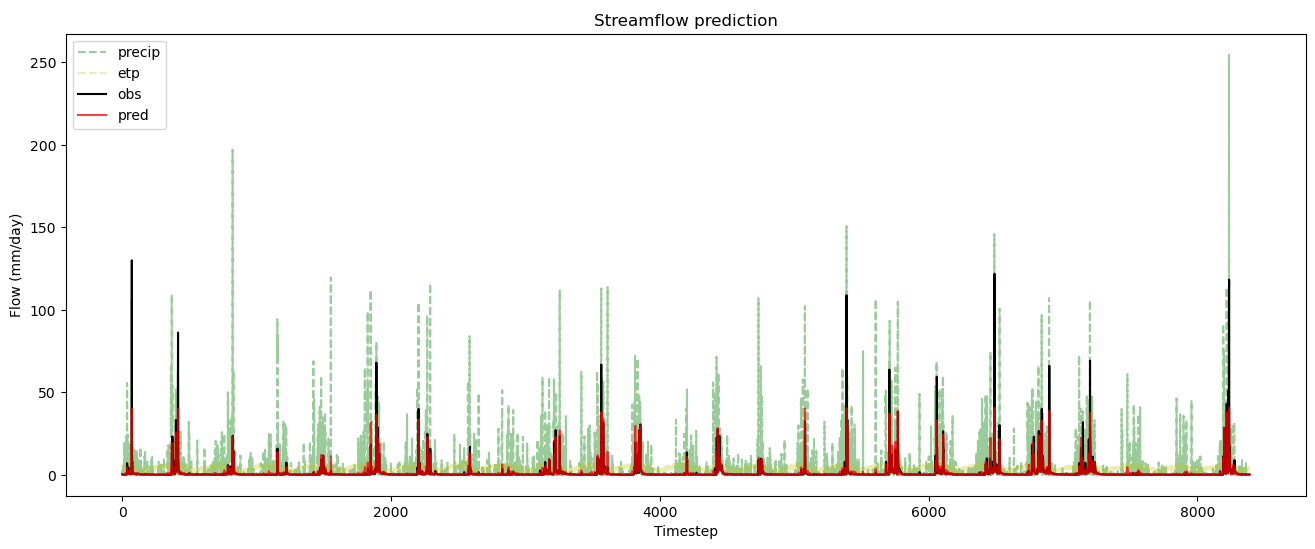

In [26]:
evaluate_preds(model, state, train_ds, batch_size=256)

(0.6261869370937347, 0.7279010711140906, <Figure size 1600x600 with 1 Axes>)

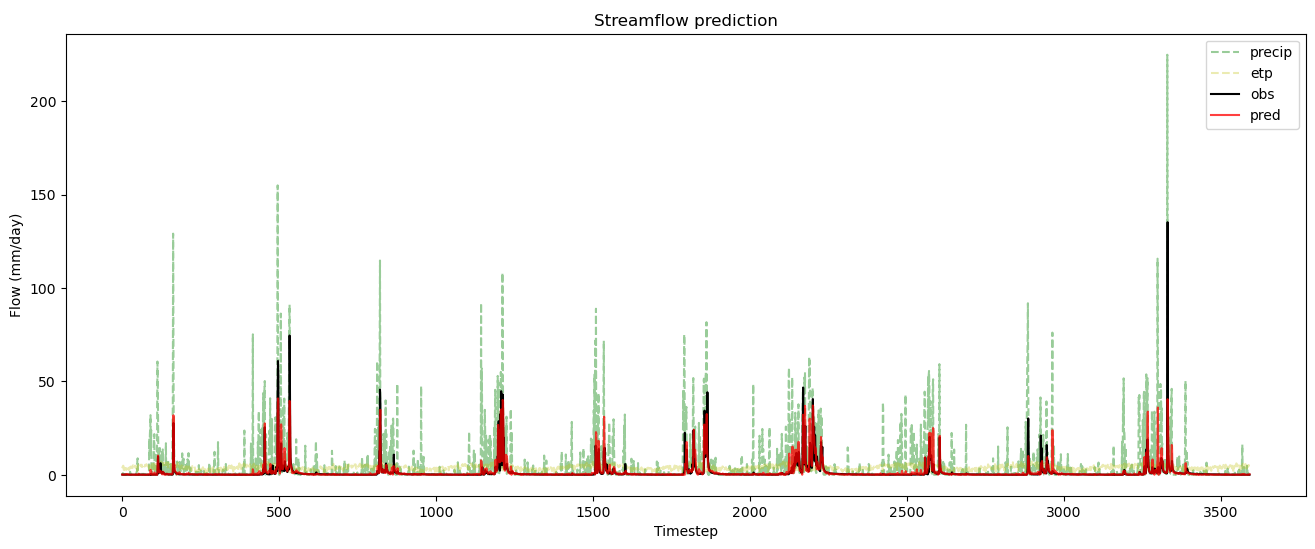

In [27]:
evaluate_preds(model, state, val_ds, batch_size=256)